This notebook explores the content inside the binary parquet train/test files. 

# Load parquet files

train.parquet: <br>

* id - A unique string identifier for the row.
* prompt - The prompt that was given as an input to both models.
* response_[a/b] - The response from model_[a/b] to the given prompt.
* winner - The judge's selection. The ground truth target column.
* model_[a/b] - The identity of model_[a/b]. Only included in train.parquet.
* language - The language used in the prompt. Only included in train.parquet.

test.parquet:

* id - A unique integer identifier for the row.
* prompt
* response_[a/b]
* scored - Whether or not the row is currently scored. During the model training phase this will be true for rows used for the public leaderboard; during the forecasting phase this will be true for rows used for the private leaderboard.

In [1]:
#libraries
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from unstructured.cleaners.core import (
    clean,
    clean_extra_whitespace,
    clean_non_ascii_chars,
    group_broken_paragraphs,
    replace_unicode_quotes,
)

In [2]:
#colors
black = mcolors.CSS4_COLORS["black"]
lime = mcolors.CSS4_COLORS["lime"]
aqua = mcolors.CSS4_COLORS["aqua"]
magenta = mcolors.CSS4_COLORS["magenta"]
red = mcolors.CSS4_COLORS["red"]
grey = mcolors.CSS4_COLORS["grey"]
orange = mcolors.CSS4_COLORS["orangered"]
gold = mcolors.CSS4_COLORS["gold"]
blue = mcolors.CSS4_COLORS["blue"]
indigo = mcolors.CSS4_COLORS["indigo"]

In [3]:
curr_path = pathlib.Path().resolve().__str__()
slash = "/"
data_path = "data/original"
train_df = pd.read_parquet(curr_path + slash + data_path + slash + "train.parquet")
test_df = pd.read_parquet(curr_path + slash + data_path + slash + "test.parquet")

# Exploratory Data Analysis (EDA)

### Train set

In [4]:
train_df.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English


In [5]:
print(f"Training set contains : {train_df.shape[0]} records")

Training set contains : 48439 records


Note: For each record we have a two model-pair comparison, i.e. for each new record there is a high probability that the selected pair models are new ones when compared to the current record.

Total models found in training set

In [6]:
np.concatenate([[train_df["model_a"].unique(),train_df["model_b"].unique()]],axis=1)

array([['o1-preview', 'gemma-2-27b-it', 'gpt-4-0125-preview',
        'gemma-2-2b-it', 'reka-flash-20240722',
        'gemini-1.5-flash-8b-exp-0827', 'claude-3-opus-20240229',
        'reka-core-20240904', 'gemini-1.5-pro-002', 'yi-lightning',
        'qwen-plus-0828', 'gemma-2-9b-it', 'o1-mini',
        'gpt-4o-mini-2024-07-18', 'claude-3-haiku-20240307',
        'llama-3.1-405b-instruct-bf16', 'llama-3.1-70b-instruct',
        'grok-2-2024-08-13', 'gemini-1.5-pro-exp-0827',
        'command-r-plus-08-2024', 'gemini-1.5-pro-001', 'qwen-max-0919',
        'gemini-1.5-flash-002', 'gemini-1.5-flash-8b-001',
        'llama-3.2-1b-instruct', 'jamba-1.5-mini',
        'chatgpt-4o-latest-20240903', 'claude-3-5-sonnet-20240620',
        'grok-2-mini-2024-08-13', 'llama-3.1-405b-instruct-fp8',
        'deepseek-v2.5', 'llama-3.1-8b-instruct', 'gpt-4o-2024-05-13',
        'reka-flash-20240904', 'llama-3.2-3b-instruct',
        'yi-lightning-lite', 'gpt-4o-2024-08-06', 'gemini-1.5-flash-001',
  

In [7]:
model_a_names_unique = train_df["model_a"].unique().reshape(-1,1)
model_b_names_unique = train_df["model_b"].unique().reshape(-1,1)

tot_models_names = np.concatenate([model_a_names_unique,model_b_names_unique],axis=0).ravel()

In [8]:
np.unique(tot_models_names)

array(['athene-70b-0725', 'c4ai-aya-expanse-32b',
       'chatgpt-4o-latest-20240808', 'chatgpt-4o-latest-20240903',
       'claude-3-5-sonnet-20240620', 'claude-3-5-sonnet-20241022',
       'claude-3-haiku-20240307', 'claude-3-opus-20240229',
       'command-r-08-2024', 'command-r-plus-08-2024',
       'deepseek-coder-v2-0724', 'deepseek-v2-api-0628', 'deepseek-v2.5',
       'gemini-1.5-flash-001', 'gemini-1.5-flash-002',
       'gemini-1.5-flash-8b-001', 'gemini-1.5-flash-8b-exp-0827',
       'gemini-1.5-flash-exp-0827', 'gemini-1.5-pro-001',
       'gemini-1.5-pro-002', 'gemini-1.5-pro-exp-0827', 'gemma-2-27b-it',
       'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-2-9b-it-simpo',
       'glm-4-plus', 'gpt-4-0125-preview', 'gpt-4-1106-preview',
       'gpt-4-turbo-2024-04-09', 'gpt-4o-2024-05-13', 'gpt-4o-2024-08-06',
       'gpt-4o-mini-2024-07-18', 'grok-2-2024-08-13',
       'grok-2-mini-2024-08-13', 'internlm2_5-20b-chat',
       'jamba-1.5-large', 'jamba-1.5-mini',
       'llama-3.

Training set contains missing data?

In [9]:
train_df.isnull().sum()

id            0
prompt        0
response_a    0
response_b    0
winner        0
model_a       0
model_b       0
language      0
dtype: int64

Training set: We have two different model responses. Therefore we have two kinds of outputs: model_a or model_b. Let's see if output is balanced.

In [10]:
train_df_winner_series = train_df["winner"].value_counts()
df_train_df_winner_series = pd.DataFrame({
    "winner" : train_df_winner_series.keys(),
    "proportion" : train_df_winner_series.values / train_df.shape[0]
})

Text(0.5, 1.0, "Winner Model's Proportion in Training Set")

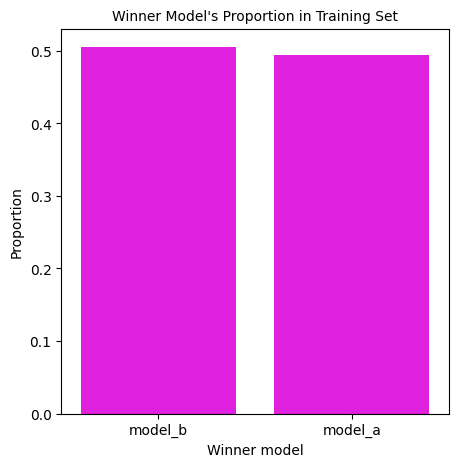

In [11]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_train_df_winner_series,x="winner",y="proportion",ax=ax,color=magenta)


#ax.tick_params(axis='x',labelrotation=90,labelsize=12)
ax.set_xlabel("Winner model",fontsize=10)
ax.set_ylabel("Proportion",fontsize=10)
ax.set_title("Winner Model's Proportion in Training Set",fontsize=10)

Human's language distribution in Training set

In [12]:
(train_df["language"].value_counts(normalize=True) > 0.002)

language
English        True
Russian        True
Chinese        True
Vietnamese     True
German         True
              ...  
Yiddish       False
Zhuang        False
Abkhazian     False
Waray         False
Sindhi        False
Name: proportion, Length: 128, dtype: bool

In [13]:
series_language = train_df["language"].value_counts(normalize=True)[(train_df["language"].value_counts(normalize=True) > 0.01).values]

df_series_language = pd.DataFrame({
    "languages" : series_language.keys(),
    "percentages" : series_language.values * 100 
})

Text(0.5, 1.0, "Language's Percentage Distribution in Training Set")

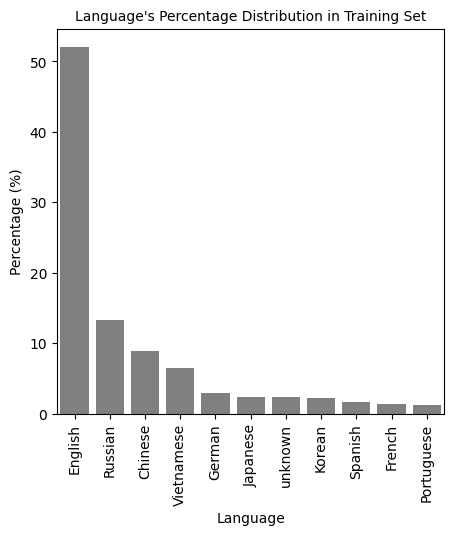

In [14]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_series_language,x="languages",y="percentages",ax=ax,color=grey)


ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Language",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Language's Percentage Distribution in Training Set",fontsize=10)

### Test set

Notes:
Not a relevant test set provided, create validation sets to measure performance of the models.

In [15]:
test_df.head()

,id,prompt,response_a,response_b,scored
0,327228,Caso Clínico: Un hombre de 70 años con anteced...,**Diagnóstico Diferencial de Anemia en Pacient...,"Basándonos en el caso clínico presentado, pode...",False
1,1139415,Peel Company received a cash dividend from a ...,The correct answer is **(a) No No**. Here's ...,The correct answer is **(a) No No**. Here's wh...,False
2,1235630,Há um grave problema com o relógio da torre da...,Dois problemas interessantes!\n\n**Problema 1:...,Vamos resolver os dois problemas em sequência....,False


# Prompt template structure

In [5]:
SYSTEM_TEMPLATE = 'You are a specialist in evaluating multilingual chat responses, with a focus on comparing and ranking outputs from different LLMs. Your primary goal is to determine which response is more likely to be preferred by humans based on factors such as clarity, relevance, tone, and overall quality.\n'

In [6]:
PROMPT_TEMPLATE = """Below is a prompt with two possible responses (**Response A** and **Response B**). Evaluate them, select the best one and answer in the following format (it is imperative that you respect the specified format, do not add any more text than what I ask for):\n1.- Write 'model_a' if the **Response A** is better than **Response B**, otherwise write 'model_b'.\n\n**Prompt**:\n{prompt}\n\n**Response A**:\n{response_a}\n\n**Response B**:\n{response_b}\n"""

In [18]:
test_prompt =train_df.iloc[4]["prompt"]
test_response_a =train_df.iloc[4]["response_a"]
test_response_b =train_df.iloc[4]["response_b"]


In [22]:
PROMPT_TEMPLATE.format(prompt=test_prompt,response_a=test_response_a,response_b=test_response_b)

"Below is a prompt with two possible responses. Evaluate them according to the system's guidelines, select the best one and answer based on the following constraints (you must strictly obey these constraints):\n\n1.- Write 'Response A' if the first response is better. On the other hand, if the second response is better,write 'Response B'.\n\n**Prompt**:\nPlease be boring \n\n**Response A**:\nAlright, I'll be as boring as possible.\n\nToday, I woke up at 6:30 AM, just like every other weekday. I made myself a cup of plain, black coffee and sat down at the kitchen table to read the newspaper. The headlines were all about the same old things: politics, economy, and weather forecasts. After finishing my coffee, I got dressed in my usual work attire and headed out the door.\n\nI took the same route to work every day, driving my trusty sedan through the quiet streets. Once I arrived at the office, I settled into my cubicle and started working on the same project I've been working on for the 

In [23]:
my_string = """
Hello! While I'm not Hatsune Miku herself, I can certainly share some popular songs that fans often associate with her. One of the beloved tracks is "World is Mine," which captures her iconic style and energy. Another favorite is "Senbonzakura," known for its catchy melody and powerful vocals. What's your favorite Hatsune Miku song? 🎶✨
"""

In [24]:

print(clean(my_string))
print(clean_non_ascii_chars(my_string))
print(replace_unicode_quotes(my_string))

Hello! While I'm not Hatsune Miku herself, I can certainly share some popular songs that fans often associate with her. One of the beloved tracks is "World is Mine," which captures her iconic style and energy. Another favorite is "Senbonzakura," known for its catchy melody and powerful vocals. What's your favorite Hatsune Miku song? 🎶✨

Hello! While I'm not Hatsune Miku herself, I can certainly share some popular songs that fans often associate with her. One of the beloved tracks is "World is Mine," which captures her iconic style and energy. Another favorite is "Senbonzakura," known for its catchy melody and powerful vocals. What's your favorite Hatsune Miku song? 


Hello! While I'm not Hatsune Miku herself, I can certainly share some popular songs that fans often associate with her. One of the beloved tracks is "World is Mine," which captures her iconic style and energy. Another favorite is "Senbonzakura," known for its catchy melody and powerful vocals. What's your favorite Hatsune

# Models' responses processing

This section intends to analyze the training set's model responses looking for anomalies. If they are, then it is convenient to clean them before storage.

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
model_name,padding_side="left",legacy=False)

In [17]:
tokenizer._special_tokens_map

{'bos_token': None,
 'eos_token': AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 'unk_token': None,
 'sep_token': None,
 'pad_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 'cls_token': None,
 'mask_token': None,
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [18]:
messages = [
                    {"role": "system", "content": SYSTEM_TEMPLATE},
                    {"role" : "user", "content" : "Hey this is a test"}
                ]

text = tokenizer.apply_chat_template(messages,add_generation_prompt=True,tokenize=True)
text

'<|im_start|>system\nYou are a specialist in evaluating multilingual chat responses, with a focus on comparing and ranking outputs from different LLMs. Your primary goal is to determine which response is more likely to be preferred by humans based on factors such as clarity, relevance, tone, and overall quality.\n<|im_end|>\n<|im_start|>user\nHey this is a test<|im_end|>\n<|im_start|>assistant\n'

In [30]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)

/home/kevinmg96/miniconda3/envs/multilingual-chatbot-arena/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/kevinmg96/miniconda3/envs/multilingual-chatbot-arena/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/kevinmg96/miniconda3/envs/multilingual-chatbot-arena/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
`loss_type=None` was set in the config b

## Visualizing number of tokens for each record

In [20]:
from datasets import Dataset
from multiprocessing import cpu_count

We will test with Qwen2.5 tokenizer

In [9]:
hf_dataset = Dataset.from_pandas(train_df)

In [34]:
from typing import List


from transformers.tokenization_utils_base import BatchEncoding


def tokenize_without_padding(records : dict[str,str]):
    #tokenize records without truncating and padding

    #apply chat template

    messages = [
                    {"role": "system", "content": SYSTEM_TEMPLATE},
                    {"role" : "user", "content" : PROMPT_TEMPLATE.format(
                    prompt=records["prompt"],response_a=records["response_a"],response_b = records['response_b'])},
                    {"role" : "assistant", "content" : records['winner']}
                ]
    tokens_id = tokenizer.apply_chat_template(messages,add_generation_prompt=True,tokenize=True)
    records["tokens_size"] = len(tokens_id)

    return records


In [39]:
hf_dataset = hf_dataset.map(tokenize_without_padding,
                            remove_columns=hf_dataset.column_names)

Map: 100%|██████████| 48439/48439 [02:13<00:00, 361.64 examples/s]


In [46]:
tokens_dataset = hf_dataset.to_pandas()

token_bins = pd.cut(tokens_dataset["tokens_size"],10)

Text(0.5, 1.0, "Number of tokens's Percentage Distribution in Training Set")

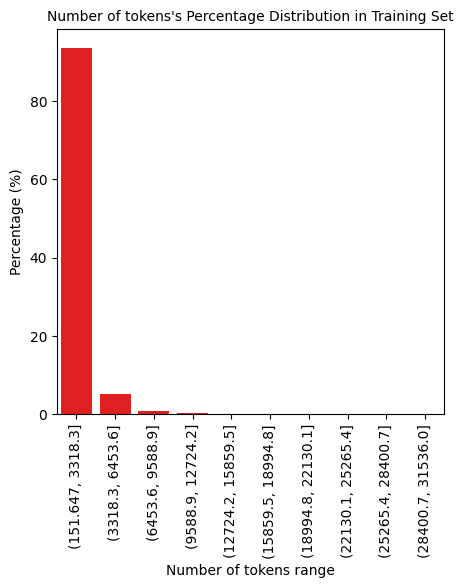

In [65]:
train_df_num_tokens = token_bins.value_counts()
train_df_num_tokens_series = pd.DataFrame({
    "bins" : train_df_num_tokens.keys(),
    "percentage" : (train_df_num_tokens.values / train_df_num_tokens.values.sum()) * 100
})

fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=train_df_num_tokens_series,x="bins",y="percentage",ax=ax,color=red)
#sns.barplot(data=df_series_language,x="languages",y="percentages",ax=ax,color=grey)


ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Number of tokens range",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Number of tokens's Percentage Distribution in Training Set",fontsize=10)


Conclusion: More than 80% of the training examples have no more than 3.4k of tokens. Then I've decided that the first models I'll try out for
fine tuning will focus solely in this subset of records.

## Testing next token probabilities extraction

In [93]:

tokenizer = AutoTokenizer.from_pretrained(model_name)

messages = [
    {'role' : 'system', 'content' : SYSTEM_TEMPLATE },
    {'role' : 'user', 'content' : PROMPT_TEMPLATE.format(prompt=record.prompt,response_a = record.response_a, response_b = record.response_b)}
]

chat = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)


model_inputs = tokenizer([chat], return_tensors="pt").to(model.device)

outputs = model.generate(**model_inputs, max_new_tokens=50, return_dict_in_generate=True, output_scores=True)
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)

input_length = model_inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | log probability | probability
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.detach().cpu().numpy():.3f} | {np.exp(score.detach().cpu().numpy()):.2%}")


""" print(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] """



|  2528 | model    | 0.000 | 100.00%
|  4306 | _a       | 0.000 | 100.00%
| 151645 | <|im_end|> | 0.000 | 100.00%


' print(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])\n\ngenerated_ids = [\n    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)\n]\n\nresponse = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] '

Note: It appears that when model is certain that model_a is better, response time is shorter than when it thinks that model_b is better. Let's test zero-shot prediction with the whole dataset to find if the model is capable of uniformely chossing between model_a and model_b. (Remember that original dataset is almost uniformely distributed among both classes.)